This notebook uses streaming for all data loading. This is crucial because the full SVQ audio dataset is hundreds of gigabytes. Streaming allows you to analyze the metadata and text immediately without downloading the audio files.

# Setup and Installation

First, we need to install the Hugging Face datasets library and pandas for data manipulation. We also import the necessary modules.

In [19]:
# Install Dependencies & Import Libraries
# @markdown Run this cell first to set up the environment (Installs soundfile, datasets, etc.)

!pip install datasets pandas tqdm matplotlib soundfile -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import load_dataset
from tqdm import tqdm
import soundfile as sf
import io

print("✅ Libraries installed and imported successfully!")

✅ Libraries installed.
✅ Libraries installed and imported successfully!


# Dataset Statistics (Audio & Locales)

Description: This cell scans the audio subset of the SVQ dataset.

* Why Streaming? The full dataset is huge (>500GB). Streaming allows us to read just the metadata (text, locale, speaker info) without downloading the heavy audio files.

* What it does: It analyzes the first 10,000 rows and prints statistics on Locales, Speaker Gender, Speaker Age, and Recording Environment.

In [5]:
# Get Dataset Statistics (Locales, Gender, Age)
# @markdown scans the dataset metadata to provide a statistical overview.

# Load the audio subset in streaming mode
audio_ds = load_dataset("google/svq", "audio", split="test", streaming=True)

data = []
limit = 10000  # Number of rows to scan (increase for more accuracy)

print(f"📊 Analyzing first {limit} rows...")

# Wrap loop with tqdm for a progress bar
for i, row in tqdm(enumerate(audio_ds), total=limit):
    if i >= limit:
        break

    # Collect metadata columns
    data.append({
        'locale': row['locale'],
        'age': row['speaker_age'],
        'gender': row['speaker_gender'],
        'environment': row['environment']
    })

df = pd.DataFrame(data)

# --- Display Statistics ---
print("\n" + "="*40)
print("DATASET STATISTICS")
print("="*40)

print("\n--- Top Locales (Distribution) ---")
print(df['locale'].value_counts().head(10))

print("\n--- Speaker Gender Distribution ---")
print(df['gender'].value_counts())

print("\n--- Recording Environment ---")
print(df['environment'].value_counts())

print("\n--- Speaker Age Stats ---")
print(df['age'].describe())

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

📊 Analyzing first 10000 rows...


100%|██████████| 10000/10000 [00:58<00:00, 169.51it/s]



DATASET STATISTICS

--- Top Locales (Distribution) ---
locale
ar_eg    10000
Name: count, dtype: int64

--- Speaker Gender Distribution ---
gender
male      5451
female    4549
Name: count, dtype: int64

--- Recording Environment ---
environment
background_speech    3465
clean                3453
media_noise          3082
Name: count, dtype: int64

--- Speaker Age Stats ---
count    10000.000000
mean        32.397600
std          6.699448
min         20.000000
25%         27.000000
50%         32.000000
75%         39.000000
max         46.000000
Name: age, dtype: float64


# Query to Wikipedia Linker

This cell connects the user's spoken Query to the specific Wikipedia Page provided in the dataset.

* Schema: It uses the document_retrieval_in_lang subset and maps text (question) to page_title.

* URL Generation: It parses the locale (e.g., te_in for Telugu) to construct the correct Wikipedia link (e.g., te.wikipedia.org).

* Demo: It automatically finds a valid example from the loaded data and prints the result.

In [11]:
# Query -> Wikipedia Linker
# @markdown Maps a query to its Ground-Truth Wikipedia page using the retrieval subset.

# Load the retrieval subset
retrieval_ds = load_dataset("google/svq", "document_retrieval_in_lang", split="test", streaming=True)

wiki_lookup = {}
scan_limit = 5000
valid_example_query = None

print(f"🔗 Building Wiki Lookup Table (scanning first {scan_limit} rows)...")

for i, row in tqdm(enumerate(retrieval_ds), total=scan_limit):
    if i >= scan_limit: break

    # Based on your provided schema:
    # 'text' is the question
    # 'page_title' is the wiki page
    q = row.get('text')
    title = row.get('page_title')

    if q and title:
        wiki_lookup[q] = {
            'title': title,
            'locale': row.get('locale', 'en_us') # Store locale to build URL later
        }

        # Save the FIRST valid example to test immediately
        if valid_example_query is None:
            valid_example_query = q

def find_wiki_page(query_text):
    """Returns the Wiki page for a query using dataset ground truth."""

    if query_text in wiki_lookup:
        info = wiki_lookup[query_text]
        title = info['title']
        loc = info['locale']

        # Construct URL: 'te_in' -> 'te', 'en_us' -> 'en'
        lang_prefix = loc.split('_')[0]
        url = f"https://{lang_prefix}.wikipedia.org/wiki/{title.replace(' ', '_')}"

        return f"✅ FOUND IN DATASET!\nQuery: {query_text}\nTitle: {title}\nURL: {url}"

    return f"⚠️ Query not found in the first {scan_limit} rows."

# --- Test with the Real Example ---
print("\n" + "="*40)
print("DEMO: QUERY TO WIKIPEDIA")
print("="*40)

if valid_example_query:
    print(find_wiki_page(valid_example_query))
else:
    print("Could not find a valid example.")

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

🔗 Building Wiki Lookup Table (scanning first 5000 rows)...


100%|██████████| 5000/5000 [00:07<00:00, 713.71it/s] 


DEMO: QUERY TO WIKIPEDIA
✅ FOUND IN DATASET!
Query: 1704년 프랑스 대통령은 누구인가요?
Title: 루이 15세
URL: https://ko.wikipedia.org/wiki/루이_15세


# Visualize Waveform & Salient Terms

This code finds a random English (en_us) example to visualize.

* Waveform: Plots the audio amplitude over time.

* Salient Terms: Highlights the specific time segments where important keywords occur.

* Audio: Embeds a player to listen to the query.

🚀 Loading 'audio_en_us_clean' subset...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

🎧 Decoding raw audio bytes manually...

📝 Query: When did the Ottoman empire conquer Italy?


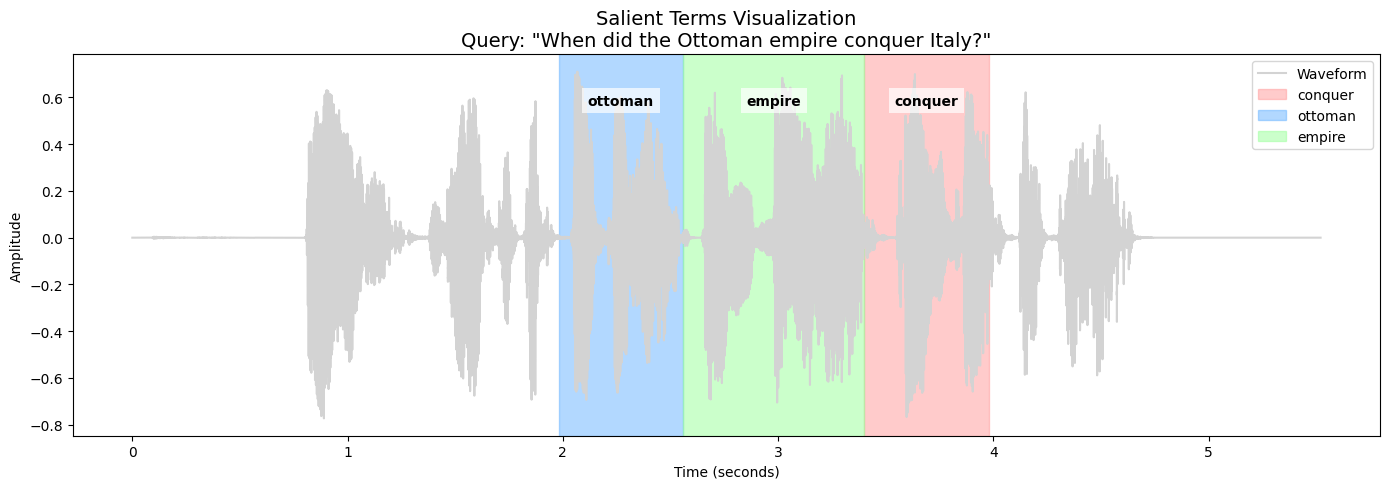

🔊 Listen below:


In [2]:
# Visualize Salient Terms (Manual Decoding Fix)


import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import load_dataset
import soundfile as sf
import io

print("🚀 Loading 'audio_en_us_clean' subset...")
# Load WITHOUT casting to Audio (this prevents the library from trying to decode it automatically)
audio_ds = load_dataset("google/svq", "audio_en_us_clean", split="test", streaming=True)

# 1. Grab the first example (Raw Data)
sample_row = next(iter(audio_ds))

# 2. Extract Metadata
text = sample_row['text']
terms = sample_row['topk_salient_terms']
timestamps = sample_row['topk_salient_terms_timestamps']

# 3. Manually Decode Audio
# The 'waveform' column contains a dictionary with a 'bytes' key
raw_audio = sample_row['waveform']

if 'bytes' in raw_audio and raw_audio['bytes']:
    print("🎧 Decoding raw audio bytes manually...")
    # Create a file-like object from the bytes and read it
    audio_arr, sr = sf.read(io.BytesIO(raw_audio['bytes']))

    duration = len(audio_arr) / sr
    time_axis = np.linspace(0, duration, len(audio_arr))

    # 4. Visualization
    plt.figure(figsize=(14, 5))
    plt.plot(time_axis, audio_arr, color='lightgray', label='Waveform')

    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

    print(f"\n📝 Query: {text}")

    for i, (term, (start, end)) in enumerate(zip(terms, timestamps)):
        color = colors[i % len(colors)]

        # Highlight the span
        plt.axvspan(start, end, color=color, alpha=0.5, label=term)

        # Add label text on plot
        mid = start + (end - start) / 2
        plt.text(mid, max(audio_arr)*0.8, term, ha='center', fontsize=10,
                 fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.title(f"Salient Terms Visualization\nQuery: \"{text}\"", fontsize=14)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 5. Play Audio
    print("🔊 Listen below:")
    ipd.display(ipd.Audio(audio_arr, rate=sr))

else:
    print("❌ Error: Audio bytes not found in the row data.")

# Interactive Inspector (Search by ID)

This is the advanced tool.

* Input: You paste a utt_id (e.g., utt_7689805010360036696) into the form field on the right side of the cell.

* Action: It searches the dataset for that ID.

* Result: It displays all metadata, the text, the waveform visualization with salient terms, and the audio player.

🔎 Scanning for ID: utt_15041124811443622614 in locale: en_us...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Scanning Dataset:  86%|████████▋ | 86425/100000 [07:12<01:07, 199.73it/s]



✅ METADATA FOUND
📝 Text:          At what temperature does steel melt?
🌍 Locale:        en_us
👤 Speaker Age:   25
⚧️ Gender:        male
🏙️ Environment:   clean


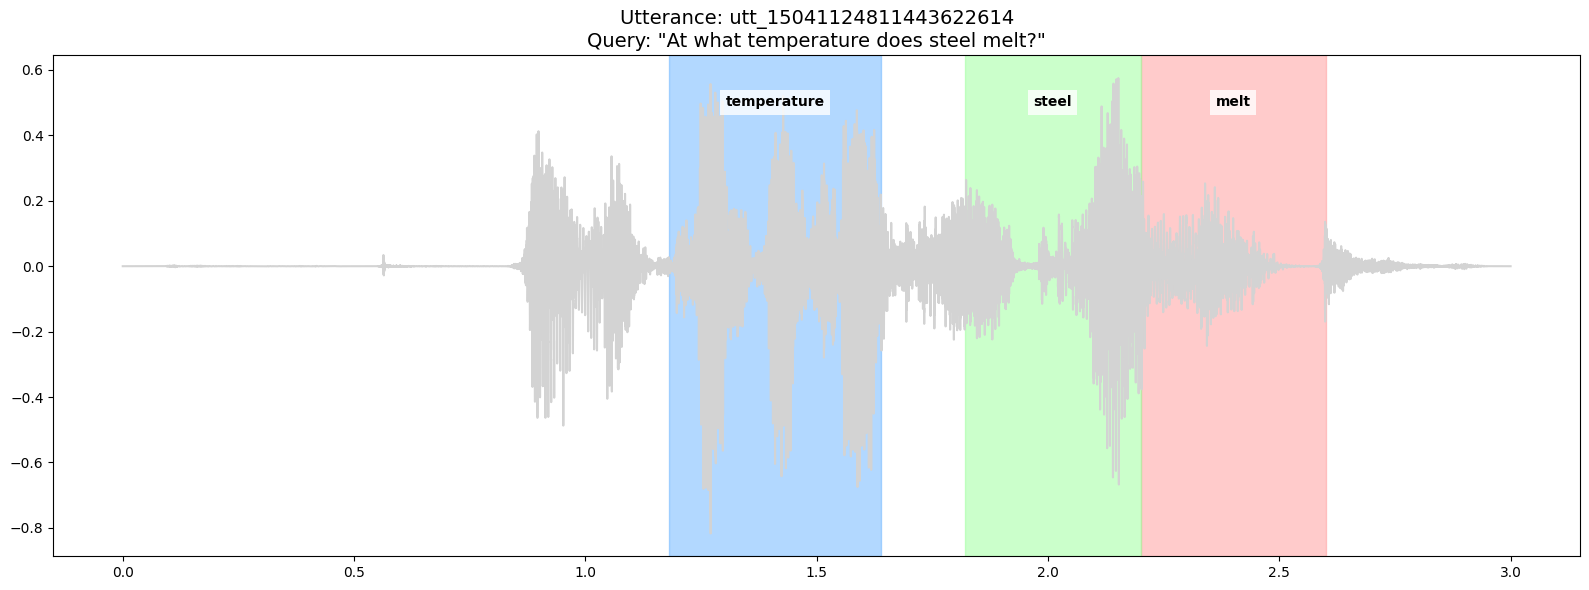


🔊 Play Audio:


In [6]:
# Interactive Utterance Inspector (with Locale)
# @markdown Select the **Locale** and enter the **utt_id** to inspect.

target_locale = "en_us" # @param ["en_us", "ar_eg", "bn_in", "de_de", "es_es", "fa_ir", "fi_fi", "id_id", "ja_jp", "ko_kr", "ru_ru", "sw_ke", "te_in", "th_th", "tr_tr", "zh_cn"]
target_utt_id = "utt_15041124811443622614" # @param {type:"string"}

# Imports needed
import soundfile as sf
import io
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import load_dataset
from tqdm import tqdm

def inspect_utterance_by_id(target_id, target_loc):
    if not target_id:
        print("Please enter a valid utt_id.")
        return

    print(f"🔎 Scanning for ID: {target_id} in locale: {target_loc}...")

    # Load the main audio subset (contains all locales)
    ds_stream = load_dataset("google/svq", "audio", split="test", streaming=True)

    found_row = None
    # We increase the limit because the ID might be far down in the stream
    search_limit = 100000

    for i, row in tqdm(enumerate(ds_stream), total=search_limit, desc="Scanning Dataset"):
        if i >= search_limit: break

        # Optimization: Fast check on locale first
        if row['locale'] != target_loc:
            continue

        # Check ID
        if row['utt_id'] == target_id:
            found_row = row
            break

    if not found_row:
        print(f"\n❌ ID '{target_id}' not found within the first {search_limit} rows.")
        return

    # --- Print Metadata ---
    print("\n" + "="*50)
    print(f"✅ METADATA FOUND")
    print(f"📝 Text:          {found_row['text']}")
    print(f"🌍 Locale:        {found_row['locale']}")
    print(f"👤 Speaker Age:   {found_row['speaker_age']}")
    print(f"⚧️ Gender:        {found_row['speaker_gender']}")
    print(f"🏙️ Environment:   {found_row['environment']}")

    # --- Manual Decode & Visualization ---
    raw_audio = found_row['waveform']

    if 'bytes' in raw_audio and raw_audio['bytes']:
        # Decode manually
        audio_arr, sr = sf.read(io.BytesIO(raw_audio['bytes']))
        duration = len(audio_arr) / sr
        time_axis = np.linspace(0, duration, len(audio_arr))

        # Plot
        plt.figure(figsize=(16, 6))
        plt.plot(time_axis, audio_arr, color='lightgray', label='Waveform')

        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

        terms = found_row['topk_salient_terms']
        timestamps = found_row['topk_salient_terms_timestamps']

        for i, (term, (start, end)) in enumerate(zip(terms, timestamps)):
            color = colors[i % len(colors)]
            plt.axvspan(start, end, color=color, alpha=0.5)

            mid = start + (end - start)/2
            plt.text(mid, max(audio_arr)*0.85, term,
                     ha='center', fontsize=10, fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        plt.title(f"Utterance: {target_id}\nQuery: \"{found_row['text']}\"", fontsize=14)
        plt.tight_layout()
        plt.show()

        print("\n🔊 Play Audio:")
        ipd.display(ipd.Audio(audio_arr, rate=sr))
    else:
        print("❌ Error: Audio data not accessible for this row.")

inspect_utterance_by_id(target_utt_id, target_locale)